In [1]:
import json
import io
import contextlib
import traceback
import os
from typing import TypedDict, List, Optional, Dict, Any

# LangGraph imports
from langgraph.graph import StateGraph, END
from langchain_core.tools import tool
import nbformat # For Jupyter notebook creation
import pandas as pd # For mock data and potential use in generated code


# --- Agent State Definition ---
class AgentState(TypedDict):
    objective: str
    plan: Optional[List[Dict[str, Any]]]  # List of tasks, e.g., {"task_id": 1, "description": "Load data"}
    current_task_id: Optional[int]
    
    # For the current task being processed
    current_task_description: Optional[str]
    generated_code: Optional[str]
    code_execution_output: Optional[str] 

    reflection_notes: Optional[str]
    review_feedback: Optional[Dict[str, Any]] # {"status": "approved", "comment": "..."} or {"status": "revise", "comment": "..."}
    
    # Accumulating results
    completed_tasks_history: List[Dict[str, Any]] 
    notebook_content: List[Dict[str, Any]] # List of cells for nbformat

    # Control flow and error tracking
    error_count: int # Cumulative errors during code execution
    max_task_revisions: int # Max revisions for a single task before replan
    current_task_revisions: int # Current revision count for the active task
    max_overall_iterations: int # Max loops through orchestrator to prevent runaway execution
    iteration_count: int # Overall iterations through the orchestrator
    final_output: Optional[str] # Final message upon completion or termination


# --- Mock LLM Call ---
# Replace this with your actual LLM API calls (e.g., OpenAI, Anthropic, Gemini)
def call_llm(prompt: str, system_message: str = "You are a helpful AI assistant.") -> str:
    """
    Mocks a call to a Large Language Model.
    In a real application, this function would interact with an LLM API.
    """
    print(f"\n--- LLM Call ---")
    print(f"System: {system_message}")
    print(f"Prompt: {prompt}")
    
    # Simulate LLM responses based on prompt keywords for demonstration
    if "plan for" in prompt.lower():
        response = '[{"task_id": 1, "description": "Load data from data.csv"}, {"task_id": 2, "description": "Clean the loaded data by removing rows with any missing values"}, {"task_id": 3, "description": "Generate a summary statistical report of the cleaned data"}]'
    elif "generate python code for task" in prompt.lower():
        if "Load data" in prompt:
            response = "import pandas as pd\ndf = pd.read_csv('data.csv')\nprint('Data loaded. First 5 rows:')\nprint(df.head())"
        elif "Clean the loaded data" in prompt:
            response = "df_cleaned = df.dropna()\nprint('Data cleaned. Shape of cleaned data:')\nprint(df_cleaned.shape)"
        elif "Generate a summary statistical report" in prompt:
            response = "print('Summary report of cleaned data:')\nprint(df_cleaned.describe())"
        else:
            response = "print('Unknown task. No code generated.')"
    elif "reflect on execution" in prompt.lower():
        if "Error during execution:" in prompt or "failed" in prompt.lower():
            response = "Execution resulted in an error. The code needs to be fixed."
        elif "Unknown task" in prompt:
            response = "Code execution seems to have processed an unknown task. Output might be irrelevant."
        else:
            response = "Execution appears successful. The output is consistent with the code."
    elif "review the code and output" in prompt.lower():
        if "Error during execution:" in prompt or "failed" in prompt.lower() or "Unknown task" in prompt:
            response = '{"status": "revise", "comment": "Execution failed or task was unclear. Please fix the code or clarify the task."}'
        elif "df = pd.read_csv('data.csv')" in prompt and "KeyError" not in prompt and "AttributeError" not in prompt:
             response = '{"status": "approved", "comment": "Data loading code and output look good."}'
        elif "df_cleaned = df.dropna()" in prompt:
             response = '{"status": "approved", "comment": "Data cleaning step approved. Output confirms rows dropped."}'
        elif "df_cleaned.describe()" in prompt:
             response = '{"status": "approved", "comment": "Summary report generation approved."}'
        else: # Default to revise if no specific match
            response = '{"status": "revise", "comment": "The code or output needs improvement or did not fully meet task criteria."}'
    else:
        response = "Default LLM response. The prompt was not recognized by the mock."
        
    print(f"LLM Response: {response}")
    return response

# --- Tool Definition (Python Code Executor) ---
@tool
def python_interpreter_tool(code: str) -> str:
    """
    Executes Python code and returns its stdout/stderr.
    WARNING: This tool uses exec() which is inherently insecure if executing untrusted code.
    In a production environment, always run code in a sandboxed, isolated environment.
    """
    print(f"\n--- Executing Code via python_interpreter_tool ---")
    print(f"Code:\n{code}")
    
    # Create a restricted globals dictionary.
    # Allow pandas if it's used in the code.
    # In a real scenario, you'd want a more robust way to manage available libraries.
    available_globals = {}
    if 'pd' in code or 'pandas' in code:
        available_globals['pd'] = pd
    
    # Capture stdout and stderr
    output_buffer = io.StringIO()
    try:
        with contextlib.redirect_stdout(output_buffer):
            with contextlib.redirect_stderr(output_buffer):
                exec(code, available_globals) # Insecure, use sandboxing in production
        result = output_buffer.getvalue()
        print(f"Execution Output:\n{result}")
        return result
    except Exception as e:
        tb_str = traceback.format_exc()
        error_msg = f"Error during execution: {str(e)}\nTraceback:\n{tb_str}"
        print(error_msg)
        return error_msg
    finally:
        output_buffer.close()

# --- Agent Node Definitions ---

def orchestrator_node(state: AgentState) -> AgentState:
    """
    Plans the workflow or moves to the next task based on the objective and feedback.
    Corresponds to node B in the flowchart.
    """
    print("\n--- Orchestrator Node (B) ---")
    state['iteration_count'] = state.get('iteration_count', 0) + 1
    if state['iteration_count'] > state.get('max_overall_iterations', 10):
        print("Max overall iterations reached. Ending workflow.")
        state['final_output'] = "Terminated: Max overall iterations reached."
        return state

    objective = state['objective']
    review_feedback = state.get('review_feedback') # Feedback from Reviewer node (I)

    # Initial planning or re-planning if requested
    if state.get('plan') is None or (review_feedback and review_feedback.get('status') == 'replan'):
        print("Orchestrator: Generating new plan.")
        prompt = f"Objective: '{objective}'. Create a concise, step-by-step JSON plan with 'task_id' and 'description' for each task."
        if review_feedback and review_feedback.get('status') == 'replan':
            prompt += f"\nRe-planning due to feedback: {review_feedback.get('comment')}"
        
        plan_str = call_llm(prompt, system_message="You are a master data science project planner.")
        try:
            plan = json.loads(plan_str)
            state['plan'] = plan
            state['current_task_id'] = plan[0]['task_id'] if plan else None
            state['completed_tasks_history'] = []
            state['notebook_content'] = [] # Reset notebook for new plan
            print(f"Orchestrator: New plan generated: {plan}")
        except (json.JSONDecodeError, IndexError) as e:
            print(f"Orchestrator: Error generating or parsing plan: {e}. Setting empty plan.")
            state['plan'] = []
            state['current_task_id'] = None
            state['error_count'] = state.get('error_count', 0) + 1
            state['final_output'] = "Terminated: Failed to generate a valid initial plan."

    elif review_feedback and review_feedback.get('status') == 'approved':
        # Current task approved, move to the next task
        current_idx = next((i for i, task in enumerate(state['plan']) if task['task_id'] == state['current_task_id']), -1)
        if current_idx != -1 and current_idx + 1 < len(state['plan']):
            next_task_id = state['plan'][current_idx + 1]['task_id']
            state['current_task_id'] = next_task_id
            print(f"Orchestrator: Moving to next task ID: {next_task_id}")
        else:
            print("Orchestrator: All tasks completed successfully.")
            state['current_task_id'] = None # Signal completion
            state['final_output'] = "Workflow successfully completed. All tasks processed."
    
    # Set current task description for the Coder
    if state.get('current_task_id') is not None and state.get('plan'):
        task = next((t for t in state['plan'] if t['task_id'] == state['current_task_id']), None)
        if task:
            state['current_task_description'] = task['description']
            state['current_task_revisions'] = 0 # Reset revisions for the new/current task
            print(f"Orchestrator: Current task set to: '{task['description']}' (ID: {state['current_task_id']})")
        else: # Should not happen if plan is consistent and tasks exist
            print(f"Orchestrator: Error - Current task ID {state['current_task_id']} not found in plan. Ending.")
            state['current_task_id'] = None 
            state['current_task_description'] = None
            state['final_output'] = f"Terminated: Task ID {state['current_task_id']} not found in plan."
    else:
        # This handles cases where all tasks are done or planning failed
        state['current_task_description'] = None
        if not state.get('final_output') and not state.get('plan'): # If planning failed and no final output yet
             state['final_output'] = "Terminated: No actionable plan."
        elif not state.get('final_output') and state.get('plan') and state.get('current_task_id') is None: # All tasks done
             state['final_output'] = "Workflow successfully completed. All tasks processed."


    state['review_feedback'] = None # Clear feedback after processing
    return state

def coder_agent_node(state: AgentState) -> AgentState:
    """
    Generates Python code for the current task.
    Corresponds to node D in the flowchart.
    """
    print("\n--- Coder Agent Node (D) ---")
    task_description = state.get('current_task_description')
    if not task_description:
        print("Coder Agent: No task description provided. Skipping code generation.")
        state['generated_code'] = "# No task description. Cannot generate code."
        return state

    previous_code = state.get('generated_code') # For revisions
    review_comment = state.get('review_feedback', {}).get('comment') # From Reviewer if it's a revision

    prompt = f"Generate Python code for the data science task: '{task_description}'."
    if state.get('current_task_revisions', 0) > 0 and review_comment:
        prompt += f"\nThis is a revision attempt. Previous feedback: '{review_comment}'."
        if previous_code:
             prompt += f"\nPrevious code was:\n{previous_code}"
    
    # System message guides the LLM's role
    code = call_llm(prompt, system_message="You are an expert Python programmer specializing in data science. Output only the raw Python code, without any surrounding text or explanations.")
    state['generated_code'] = code
    print(f"Coder Agent: Generated code for task '{task_description}'.")
    return state

def code_executor_node(state: AgentState) -> AgentState:
    """
    Executes the generated Python code using the python_interpreter_tool.
    Corresponds to the tool E in the flowchart.
    """
    print("\n--- Code Executor Node (E) ---")
    code_to_execute = state.get('generated_code')
    if code_to_execute and code_to_execute.strip() and not code_to_execute.startswith("# No task"):
        # Invoke the tool (defined with @tool decorator)
        execution_output = python_interpreter_tool.invoke({"code": code_to_execute})
        state['code_execution_output'] = execution_output
        if "Error during execution:" in execution_output:
            state['error_count'] = state.get('error_count', 0) + 1
            print("Code Executor: Error detected during execution.")
    else:
        state['code_execution_output'] = "No valid code provided to execute or task was unclear."
        print("Code Executor: No valid code to execute.")
    return state

def reflection_node(state: AgentState) -> AgentState:
    """
    Reflects on the code execution output.
    Corresponds to node G in the flowchart.
    """
    print("\n--- Reflection Node (G) ---")
    task_desc = state.get('current_task_description', "N/A")
    code = state.get('generated_code', "N/A")
    output = state.get('code_execution_output', "N/A")
    
    prompt = f"Task: {task_desc}\nCode:\n{code}\nExecution Output:\n{output}\n\nReflect on the execution. Was it successful? Any issues? What does the output signify in relation to the task? Be concise."
    reflection = call_llm(prompt, system_message="You are a code execution analyst. Provide brief reflections.")
    state['reflection_notes'] = reflection
    print(f"Reflection Node: Reflection generated for task '{task_desc}'.")
    return state

def reviewer_node(state: AgentState) -> AgentState:
    """
    Reviews the code, execution output, and reflection.
    Corresponds to node I in the flowchart.
    """
    print("\n--- Reviewer Node (I) ---")
    task_desc = state.get('current_task_description', "N/A")
    code = state.get('generated_code', "N/A")
    output = state.get('code_execution_output', "N/A")
    reflection = state.get('reflection_notes', "N/A")

    prompt = (f"Review the following for task '{task_desc}':\n"
              f"Code:\n{code}\n\n"
              f"Execution Output:\n{output}\n\n"
              f"Reflection:\n{reflection}\n\n"
              f"Is the code correct and does the output achieve the task goal? "
              f"Respond in JSON format with 'status' ('approved', 'revise', or 'replan') and a 'comment'.")
    review_str = call_llm(prompt, system_message="You are a meticulous QA agent. Review code, output, and reflection thoroughly.")
    try:
        review = json.loads(review_str)
        state['review_feedback'] = review
        if review.get("status") == "revise":
            state['current_task_revisions'] = state.get('current_task_revisions', 0) + 1
        print(f"Reviewer Node: Review for task '{task_desc}': {review.get('status')}")
    except json.JSONDecodeError:
        print("Reviewer Node: Error - Failed to parse JSON feedback from LLM. Defaulting to 'revise'.")
        state['review_feedback'] = {"status": "revise", "comment": "Reviewer LLM error: Invalid JSON response."}
        state['current_task_revisions'] = state.get('current_task_revisions', 0) + 1
    return state

def write_to_notebook_node(state: AgentState) -> AgentState:
    """
    Writes the approved code, output, and reflection to the notebook content.
    Corresponds to node J in the flowchart.
    """
    print("\n--- Write to Notebook Node (J) ---")
    if state.get('review_feedback', {}).get('status') == 'approved':
        task_desc = state.get('current_task_description', "Task Description Missing")
        code = state.get('generated_code', "# No code generated")
        exec_output = state.get('code_execution_output', "")
        reflection = state.get('reflection_notes', "No reflection.")
        review_comment = state.get('review_feedback', {}).get('comment', "No review comment.")

        # Format code execution output for nbformat
        # nbformat expects a list of output dicts (e.g., for stdout, stderr, display_data)
        formatted_outputs = []
        if exec_output:
            # Simple stream output for stdout/stderr
            formatted_outputs.append({
                "name": "stdout", 
                "output_type": "stream", 
                "text": exec_output.splitlines(True) # Keep newlines for list of strings
            })
        
        # Create markdown cell for reflection and review
        reflection_md_source = (f"## Task: {task_desc}\n\n"
                                f"**Reflection:**\n{reflection}\n\n"
                                f"**Reviewer Comment:**\n{review_comment}")
        
        reflection_cell = nbformat.v4.new_markdown_cell(source=reflection_md_source)
        
        # Create code cell
        code_cell = nbformat.v4.new_code_cell(
            source=code,
            outputs=formatted_outputs,
            execution_count=None # Can be managed if tracking execution order
        )
        
        if 'notebook_content' not in state or state['notebook_content'] is None:
            state['notebook_content'] = []
        
        state['notebook_content'].append(reflection_cell)
        state['notebook_content'].append(code_cell)
        
        # Log completed task
        if 'completed_tasks_history' not in state or state['completed_tasks_history'] is None:
            state['completed_tasks_history'] = []
        state['completed_tasks_history'].append({
            "task_id": state['current_task_id'],
            "description": task_desc,
            "code": code,
            "output": exec_output,
            "reflection": reflection,
            "review": state['review_feedback']
        })
        print(f"Write to Notebook: Task '{task_desc}' and its reflection/review written.")
    else:
        print(f"Write to Notebook: Skipped as task '{state.get('current_task_description')}' was not approved.")
    return state

# --- Conditional Edge Functions ---

def should_continue_from_orchestrator(state: AgentState) -> str:
    """
    Decision point after the Orchestrator node.
    Routes to coding loop (C->D) or ends workflow (K).
    """
    print("\n--- Decision: Continue from Orchestrator? ---")
    if state.get('final_output'): # Set if max iterations, all tasks done, or critical error
        print(f"Orchestrator Decision: Final output detected ('{state['final_output']}'). Ending workflow (K).")
        return "end_workflow"
        
    if state.get('current_task_id') is not None and state.get('plan') and state.get('current_task_description'):
        print(f"Orchestrator Decision: Proceeding with task '{state['current_task_description']}'. Route to Coder Agent (D).")
        return "start_coding_loop" # This signifies B -> C (entry to task processing) -> D
    else:
        print("Orchestrator Decision: No current task or plan is invalid. Ending workflow (K).")
        if not state.get('final_output'): # Ensure final output is set if not already
             state['final_output'] = "Terminated: No actionable task or plan invalid after orchestration."
        return "end_workflow"

def route_after_review(state: AgentState) -> str:
    """
    Decision point after the Reviewer node (I).
    Routes to:
    - Write to Notebook (J) if approved.
    - Coder Agent (D) if revision is needed and revisions not maxed out.
    - Orchestrator (B) if re-plan is needed or revisions maxed out.
    """
    print("\n--- Decision: Route after Review ---")
    review_status = state.get('review_feedback', {}).get('status')
    current_revisions = state.get('current_task_revisions', 0)
    max_revisions = state.get('max_task_revisions', 2) # Default max revisions per task

    if review_status == 'approved':
        print(f"Reviewer Decision: Task '{state.get('current_task_description')}' approved. Route to Write to Notebook (J).")
        return "write_to_notebook" # I -> (H -> J) in flowchart
    elif review_status == 'revise':
        if current_revisions < max_revisions:
            print(f"Reviewer Decision: Task '{state.get('current_task_description')}' needs revision (Attempt {current_revisions+1}/{max_revisions}). Route back to Coder Agent (D).")
            return "revise_code" # I -> D (feedback loop)
        else:
            print(f"Reviewer Decision: Max revisions ({max_revisions}) reached for task '{state.get('current_task_description')}'. Requesting re-plan. Route to Orchestrator (B).")
            # Modify review_feedback to signal re-plan to orchestrator
            state['review_feedback'] = {
                "status": "replan", 
                "comment": f"Max revisions reached for task '{state.get('current_task_description')}'. Original review: {state.get('review_feedback', {}).get('comment')}"
            }
            return "send_feedback_to_orchestrator" # I -> B
    elif review_status == 'replan':
        print(f"Reviewer Decision: Re-plan explicitly requested for task '{state.get('current_task_description')}'. Route to Orchestrator (B).")
        return "send_feedback_to_orchestrator" # I -> B
    else: # Default or unknown status
        print(f"Reviewer Decision: Unknown review status ('{review_status}') for task '{state.get('current_task_description')}'. Defaulting to re-plan. Route to Orchestrator (B).")
        state['review_feedback'] = {"status": "replan", "comment": f"Unknown review status '{review_status}', forcing re-plan."}
        return "send_feedback_to_orchestrator"


# --- Build the LangGraph Workflow ---
workflow = StateGraph(AgentState)

# Add nodes (B, D, E, G, I, J from flowchart)
workflow.add_node("orchestrator", orchestrator_node)       # B
workflow.add_node("coder_agent", coder_agent_node)         # D
workflow.add_node("code_executor", code_executor_node)     # E (as a direct execution step)
workflow.add_node("reflection", reflection_node)           # G
workflow.add_node("reviewer", reviewer_node)               # I
workflow.add_node("write_to_notebook", write_to_notebook_node) # J

# Set the entry point
workflow.set_entry_point("orchestrator") # A -> B

# Define edges based on flowchart logic
# B (orchestrator) -> conditional (to Coder D or End K)
workflow.add_conditional_edges(
    "orchestrator",
    should_continue_from_orchestrator,
    {
        "start_coding_loop": "coder_agent", # B -> C (conceptual) -> D
        "end_workflow": END                 # B -> K
    }
)

# D (coder_agent) -> E (code_executor)
workflow.add_edge("coder_agent", "code_executor") # D -> E

# E (code_executor) -> F (conceptual end of D-E pass) -> G (reflection)
workflow.add_edge("code_executor", "reflection") # E -> (F) -> G

# G (reflection) -> H (conceptual end of G) -> I (reviewer)
workflow.add_edge("reflection", "reviewer") # G -> (H) -> I

# I (reviewer) -> conditional routing
workflow.add_conditional_edges(
    "reviewer",
    route_after_review,
    {
        "write_to_notebook": "write_to_notebook",       # I -> (H -> J path)
        "revise_code": "coder_agent",                   # I -> D (feedback loop for revision)
        "send_feedback_to_orchestrator": "orchestrator" # I -> B (feedback loop for re-plan or next task)
    }
)

# J (write_to_notebook) -> B (orchestrator for next task or to end workflow)
workflow.add_edge("write_to_notebook", "orchestrator") # J -> B (Orchestrator then decides if K or C)

# Compile the graph
app = workflow.compile()


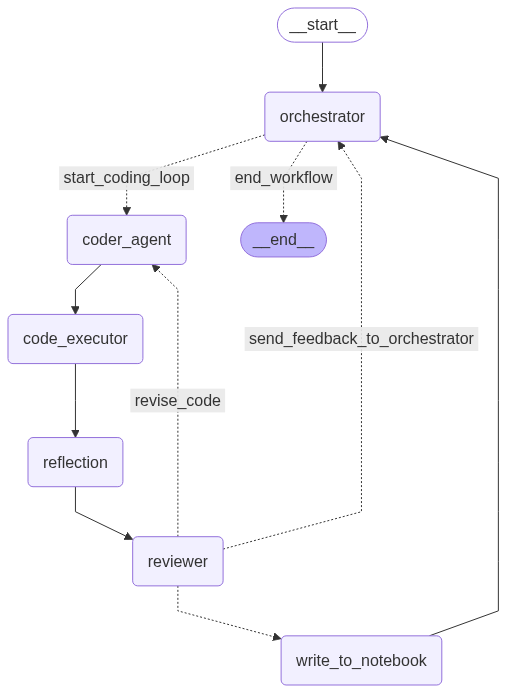

In [2]:
app

In [39]:
import operator
from typing import TypedDict, List, Optional

from langgraph.graph import StateGraph, END

# --- Minimal State Definition ---
class AgentState(TypedDict):
    """A minimal state for demonstrating the workflow structure."""
    objective: Optional[str]
    feedback: Optional[str]
    fatal_error: bool
    review_status: Optional[str] # e.g., 'continue', 'end', 'replan'
    steps_taken: int
    tools: List[str]  # Added tools list

# --- Node Functions ---

def orchestrator_agent(state: AgentState) -> dict:
    """Orchestrator agent with tool management."""
    print("--- Orchestrator Node ---")
    tools = state.get("tools", [])
    if not tools:
        tools = ["code_generator", "data_analyzer", "visualizer"]
    return {
        "steps_taken": state.get("steps_taken", 0) + 1,
        "tools": tools
    }

def tool_agent(state: AgentState) -> dict:
    """Tool agent that executes specific tools."""
    print("--- Tool Node ---")
    tools = state.get("tools", [])
    print(f"Executing tools: {tools}")
    return {"steps_taken": state.get("steps_taken", 0) + 1}

def coder_agent(state: AgentState) -> dict:
    """Coder agent with tool usage."""
    print("--- Coder Node ---")
    tools = state.get("tools", [])
    print(f"Available tools: {tools}")
    return {"steps_taken": state.get("steps_taken", 0) + 1}

def reflection_agent(state: AgentState) -> dict:
    """Reflection agent with end condition."""
    print("--- Reflection Node ---")
    steps = state.get("steps_taken", 0)
    if steps >= 10:  # End after 10 steps
        return {"fatal_error": True, "steps_taken": steps + 1}
    return {"fatal_error": False, "steps_taken": steps + 1}

def reviewer_agent(state: AgentState) -> dict:
    """Reviewer agent with enhanced status handling."""
    print("--- Reviewer Node ---")
    steps = state.get("steps_taken", 0)
    if steps < 5:
        status = "continue"
        feedback = ""
    else:
        status = "end"
        feedback = "Maximum steps reached"
    print(f"    Reviewer decision: {status}")
    return {
        "review_status": status,
        "feedback": feedback,
        "steps_taken": steps + 1
    }

# --- Conditional Edge Functions ---

def reflector_next_step(state: AgentState) -> str:
    """Enhanced reflector routing with end condition."""
    print("--- Reflector Decision ---")
    if state.get("fatal_error", False):
        print("    -> END (Fatal Error)")
        return "end"
    elif state.get("steps_taken", 0) >= 10:
        print("    -> END (Max Steps)")
        return "end"
    else:
        print("    -> Coder")
        return "coder"

def reviewer_next_step(state: AgentState) -> str:
    """Enhanced reviewer routing with tool feedback."""
    print("--- Reviewer Decision ---")
    status = state.get("review_status", "end")
    feedback = state.get("feedback", "")

    if feedback:
        print("    -> Orchestrator (Feedback)")
        return "orchestrator"
    elif status == "continue":
        print("    -> Coder (Continue)")
        return "coder"
    else:
        print("    -> END")
        return "end"

def code_writer(state):
    pass


# --- Build the Graph ---

print("Building the LangGraph workflow...")

workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("orchestrator", orchestrator_agent)
workflow.add_node("coder", coder_agent)
workflow.add_node("reflector", reflection_agent)
workflow.add_node("reviewer", reviewer_agent)

workflow.add_node("code_writer", code_writer)

# Set entry point
workflow.set_entry_point("orchestrator")

# Add edges
workflow.add_edge("orchestrator", "coder")
workflow.add_edge("coder", "reflector")  # Changed from tool to reflector
workflow.add_edge("reflector", "coder")  # Added reflector to coder edge

workflow.add_edge("reflector", "reviewer")  # Added reflector to coder edge
workflow.add_edge("reflector", "code_writer")  # Added reflector to coder edge

workflow.add_edge("orchestrator", END)  # Added reflector to coder edge

# Add conditional edge from reviewer
workflow.add_edge(
    "reviewer","orchestrator")

# Compile the graph
app = workflow.compile()

Building the LangGraph workflow...


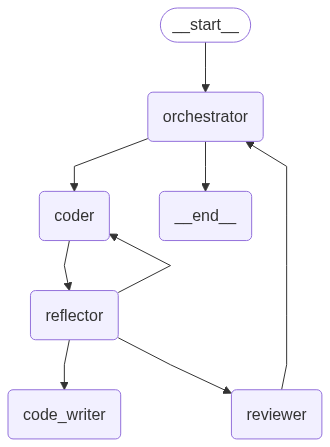

In [40]:
app

In [1]:
# Create a crew with just the orchestrator

from crewai import Agent, Task, Crew, Process
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.messages import HumanMessage, SystemMessage
import json
import os

with open('config.json', 'r') as f:
    config = json.load(f)

# Set OpenAI environment variables
os.environ["OPENAI_API_KEY"] = config['apiKey']
os.environ["OPENAI_API_BASE"] = config['baseURL']
os.environ["OPENAI_PUBLISHER"] = config['publisher']

# Initialize LangChain's ChatOpenAI
llm = ChatOpenAI(
    api_key=config['apiKey'],
    model=config['model'],
    base_url="https://models.github.ai/inference",
    temperature=0.7
)

# Define the system prompt for planning
PLANNER_SYSTEM_PROMPT = """You are an expert project manager and data science planner. Your role is to break down objectives into clear, actionable steps.

Your planning should:
1. Be extremely detailed and specific
2. Include all necessary steps
3. Consider dependencies between steps
4. Account for potential challenges
5. Define clear success criteria

For each step, you must specify:
- What needs to be done
- Required inputs
- Expected outputs
- Success criteria
- Potential challenges to handle

Format your response as a clear, numbered list of steps."""

# Define the planning chain
def create_planning_chain():
    # Create the prompt template
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=PLANNER_SYSTEM_PROMPT),
        HumanMessage(content="{objective}")
    ])
    
    # Create the chain
    chain = (
        {"objective": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    
    return chain

def plan_objective(objective):
    """
    Creates a detailed plan for the given objective using LangChain.
    
    Args:
        objective (str): The objective to plan for
        
    Returns:
        str: The detailed plan
    """
    try:
        # Create the planning chain
        planning_chain = create_planning_chain()
        
        # Generate the plan
        plan = planning_chain.invoke(objective)
        
        return plan
    except Exception as e:
        print(f"Error during planning: {e}")
        return None
